<a href="https://colab.research.google.com/github/jpsiegel/Projects/blob/master/Tarea3_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tarea 3 Jan P. Siegel - Deep Learning


##Allocate resources

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil

import os
import GPUtil as GPU
import psutil
import humanize

In [2]:

GPUs = GPU.getGPUs()
gpu = GPUs[0]  # Only one GPU on Colab and not guaranteed

def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " | Used: " + humanize.naturalsize(process.memory_info().rss))
  print("VRAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

RAM Free: 12.8 GB  | Used: 118.3 MB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
my_dir = "/content/drive/MyDrive/DL"

Mounted at /content/drive


In [3]:
# Download Roms
!wget http://www.atarimania.com/roms/Roms.rar > /dev/null
# Decompresed files
!unrar e Roms.rar > /dev/null
!unzip 'ROMS.zip' > /dev/null
# Add Roms folder to atary_py PATH
!python -m atari_py.import_roms 'ROMS' > /dev/null
# > /dev/null omits command output

--2021-06-27 22:04:51--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M   836KB/s    in 13s     

2021-06-27 22:05:05 (807 KB/s) - ‘Roms.rar’ saved [11128004/11128004]



##Preprocessing


In [5]:
import gym
from gym import spaces
import cv2

# pasar a escala de grises y recortar imagen
def _process_frame84(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = frame[:155,10:]
    #x_t = cv2.resize(frame, (84, 84),  interpolation=cv2.INTER_LINEAR)
    x_t = cv2.resize(frame, (84, 84),interpolation=cv2.INTER_AREA)
    return x_t.astype(np.uint8)

class ProcessFrame84(gym.Wrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = spaces.Box(low=0, high=255, shape=(84, 84))

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return _process_frame84(obs), reward, done, info

    def reset(self):
        return _process_frame84(self.env.reset())

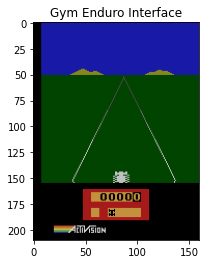

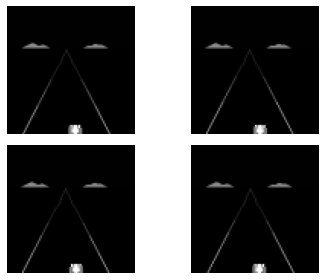

obs shape: (4, 84, 84)
actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE'] amount: 9


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
from gym.wrappers import AtariPreprocessing
from gym.wrappers import FrameStack

#Create environment
game = 'Enduro-v0'
env = gym.make(game,frameskip=4)

# For reproducibility
seed = 0
env.seed(seed)

obs = env.reset()

plt.imshow(np.squeeze(obs))
plt.title('Gym Enduro Interface')
plt.show()

env = ProcessFrame84(env) # pasamos el wrapper al enviroment
env = FrameStack(env,num_stack=4) # un estado definido como el actual mas los 3 anteriores
obs = env.reset()

for _ in range(100):
  action = random.randint(0,env.action_space.n-1) # seleccionar accion random
  obs, reward, done, info = env.step(action)

plt.figure()
plt.subplot(2,2,1)
plt.imshow(np.squeeze(np.array(obs)[0,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.squeeze(np.array(obs)[1,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(np.squeeze(np.array(obs)[2,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(np.squeeze(np.array(obs)[3,:,:]),cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

print("obs shape:", obs.shape)
print("actions:", env.get_action_meanings(), "amount:", env.action_space.n)

### Fill replay memory

In [50]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = [] # Can be a list a Deque or another type of list
        self.next_replace_position = 0

    def push(self, state, action, next_state, reward, done):
        """Saves a transition.
        e.g. ('state', 'action', 'next_state', 'reward','done')
        """
        memory_data = (state, action, next_state, reward, done)
        if len(self) >= self.capacity:
          self.memory[self.next_replace_position] = memory_data
          self.next_replace_position += 1
          if self.next_replace_position > self.capacity - 1:
            self.next_replace_position = 0
        else:
          self.memory.append(memory_data)

    def sample(self, batch_size):
       """ Samples a transition with a defined batch size"""
       sampled_tuples = random.sample(self.memory, batch_size) # list of tuples
       sampled_states = []
       sampled_actions = []
       sampled_n_states = []
       sampled_rewards = []
       sampled_dones = []
       for i in range(batch_size):
         sampled_states.append(sampled_tuples[i][0])
         sampled_actions.append(sampled_tuples[i][1])
         sampled_n_states.append(sampled_tuples[i][2])
         sampled_rewards.append(sampled_tuples[i][3])
         sampled_dones.append(sampled_tuples[i][4])
       return (sampled_states, sampled_actions, sampled_n_states, sampled_rewards, sampled_dones)
      
    def __len__(self):
        return len(self.memory)

In [51]:
memory_size = 500000
replay_memory = ReplayMemory(memory_size)

current_obs = env.reset()
for _ in range(memory_size):
  #print(_, replay_memory.next_replace_position, len(replay_memory))
  action = random.randint(0,env.action_space.n-1) # seleccionar accion random
  obs, reward, done, info = env.step(action)
  replay_memory.push(current_obs, action, obs, reward, done)
  current_obs = obs
  if done: # si pierde partimos nuevo episodio
    current_obs = env.reset()
  else:
    current_obs = obs

In [79]:
from torch import tensor, device
device = device('cuda' if torch.cuda.is_available() else 'cpu')
obs, _, _, _, _ = replay_memory.sample(2)
print(obs)
to_tensor = tensor(obs).to(device)
print(to_tensor.shape) # batch_size x frames x size_h x size_w
print(to_tensor.dtype, to_tensor.device)
to_tensor = to_tensor/255 #normalizado
print(to_tensor.dtype, to_tensor.device)

[<gym.wrappers.frame_stack.LazyFrames object at 0x7f57b0080590>, <gym.wrappers.frame_stack.LazyFrames object at 0x7f57b0080fb0>]
torch.Size([2, 4, 84, 84])
torch.uint8 cuda:0
torch.float32 cuda:0


##Model

In [28]:
import torch
import torch.nn as nn
import numpy as np

class Dueling_DQN(nn.Module):
    def __init__(self, in_channels, num_actions):
        super(Dueling_DQN, self).__init__()
        self.num_actions = num_actions
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)

        self.fc1_adv = nn.Linear(in_features=7*7*64, out_features=512)
        self.fc1_val = nn.Linear(in_features=7*7*64, out_features=512)

        self.fc2_adv = nn.Linear(in_features=512, out_features=num_actions)
        self.fc2_val = nn.Linear(in_features=512, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):

        # TODO: forward pass red convolucional
        
        # TODO: forward pass rama fully-connected para V(s)
        
        # TODO: forward pass rama fully-connected para A(s,a)
        
        # TODO: Calculo de Q(s,a) a partir de ecuacion (4)

        return Q_values

##Training

In [29]:
def exploration(total_steps):
  """ retorna probabilidad de que explore con accion random """
  if total_steps >= 1000000:
    epsilon = 0.1
  else:
    m = -0.9 / 1000000
    n = 1
    epsilon = m * total_steps + n
  return epsilon

In [66]:
# Define parameters and instance NNs

from torch import device
import torch.optim as optim
import torch.nn as nn

device = device('cuda' if torch.cuda.is_available() else 'cpu')

frame_history_len = 4 # Cantidad de frames de cada estado (definido en el pre-procesamiento)
batch_size = 32
gamma = 0.99 # Factor de descuento
learning_starts = 50000 # Paso en que se comienza a utilizar la red para escoger acciones (siguiendo política e-greedy)
learning_freq = 4 # Frecuencia de pasos en que se modifican los pesos (loss backprop) en la red Q
target_update_freq = 10000 # Frecuencia en que se actualizan los pesos de la red target Q' (cada x backprops, updateo Q')
LR = 0.00025 # Tasa de aprendizaje

in_channels = frame_history_len
input_shape = (84,84)
num_actions = env.action_space.n

# define Q target and Q 
Q = Dueling_DQN(in_channels, num_actions).to(device) # esta es la que de verdad quiero entrenar
Q_target = Dueling_DQN(in_channels, num_actions).to(device) # para estabilidad, esta me entrega los labels

# Optimizador, pueden elegir entre Adam o RMSProp
optimizer = optim.Adam(Q.parameters(), lr=LR)

# Criterio de pérdida
loss = nn.MSELoss()

LOG_EVERY_N_STEPS = 50000 # (Opcional) Frecuencia en la que se muestran resultados en consola
STEPS_PER_EPOCH = 250000 # Pasos por época
N_EPOCHS = 20 # Número de épocas

In [ ]:
from tqdm import tqdm
from torch import tensor, no_grad

# Load checkpoint: probablemente se quede sin memoria durante entrenamiento,
# por eso hay que guardar checkpoint (pesos) en drive cada cierto tiempo
# luego cargamos checkpoint, rellenamos memory buffer, y retomamos
# pero el rellenado debe ser usando el modelo que tenemos hasta ahora! no random como el inicial

# Reseteamos nuestro ambiente para empezar el entrenamiento
last_obs = env.reset()
for epoch in tqdm(range(N_EPOCHS),position=0,leave=True):
  for t in tqdm(range(STEPS_PER_EPOCH),position=0,leave=True):
    
    ### 1. Before learning starts, choose actions and update replay memory buffer
    if t < learning_starts:
      action = np.random.randint(num_actions)
    else:
      # epsilon greedy exploration
      sample = random.random()
      total_steps = t + STEPS_PER_EPOCH * epoch # steps acumulados a traves de las epocas
      threshold = exploration(total_steps)  # la funcion exploration permite calcular el threshold para la política e-greedy
      if sample <= threshold:
        action = np.random.randint(num_actions)
      else:
        with no_grad(): # no actualizamos gradientes pq estamos evaluando
          # Selecciono la acción segun la red Q
          # aca le hago un forward pass Q(last_obs) y saco el nro de accion que mayor valor que me retorna
          pass

    obs, reward, done, _ = env.step(action)

    replay_memory.push(last_obs, action, obs, reward, done)
    if done:
      obs = env.reset()
      # termino episodio!
      # Guardar reward acumulado del episodio

    # update last_obs
    last_obs = obs

    ### 2. Perform experience replay and train the network.
    if (t > learning_starts and t % learning_freq == 0):
      obs_t, act_t, next_obs, rew_t, done_mask = replay_memory.sample(batch_size) # esto me deja listas de largo batch size
          
      # Pasar los arreglos a tensores y al device actual
      obs_t = tensor(obs_t).to(device)
      act_t = tensor(act_t).to(device)
      next_obs = tensor(next_obs).to(device)
      rew_t = tensor(rew_t).to(device)
      done_mask = tensor(done_mask).to(device)

      # Normalizar tensores de entrada # HAY ALGO MAS QUE SEA TENSOR DE ENTRADA??
      obs_t = obs_t/255

      # input batches to networks
      q_values = Q(obs_t)

      # Loss calculation
      #calcular labels, 1:13:00 y 1:23:00 de ayud

      # backwards pass
      optimizer.zero_grad()

      loss.backward()
      # update
      optimizer.step()

      # Actualizar pesos de red target (cada target_update_freq actualizaciones de los parámetros de Q)

    
    if t % LOG_EVERY_N_STEPS == 0:
      # Mostrar resultados actuales
      # e.g. Mejor reward y promedio de ultimos 100 episodios
      # entre otros.
      pass

    # Guardar modelo y resultados!
    # importante si se les cierra el entrenamiento

## Results

###Testing visualization

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

frames_show = frames[:300]

plt.figure(figsize=(frames_show[0].shape[1] / 15.0, frames_show[0].shape[0] / 15.0), dpi = 72)
patch = plt.imshow(frames_show[0],cmap='gray')
plt.axis('off')
animate = lambda i: patch.set_data(frames_show[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames_show), interval = 100)
HTML(ani.to_jshtml())